In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics
from collections import Counter
import re
#NLTK

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
!wget https://github.com/johnksander/twitter_NLP_analysis/raw/master/training.1600000.processed.noemoticon.csv.zip
!unzip training.1600000.processed.noemoticon.csv.zip

--2020-09-12 01:12:50--  https://github.com/johnksander/twitter_NLP_analysis/raw/master/training.1600000.processed.noemoticon.csv.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/johnksander/twitter_NLP_analysis/master/training.1600000.processed.noemoticon.csv.zip [following]
--2020-09-12 01:12:50--  https://raw.githubusercontent.com/johnksander/twitter_NLP_analysis/master/training.1600000.processed.noemoticon.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85088716 (81M) [application/zip]
Saving to: ‘training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[============

In [3]:
sentiment140 = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',header=None)
sentiment140.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
header= ['target','id','date','flag','user','text']
sentiment140.set_axis(header,axis=1,inplace=True)
sentiment140=sentiment140.drop(['id','date','flag','user'],axis=1)
sentiment140.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

sentiment140.target = sentiment140.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Labels distribuition')

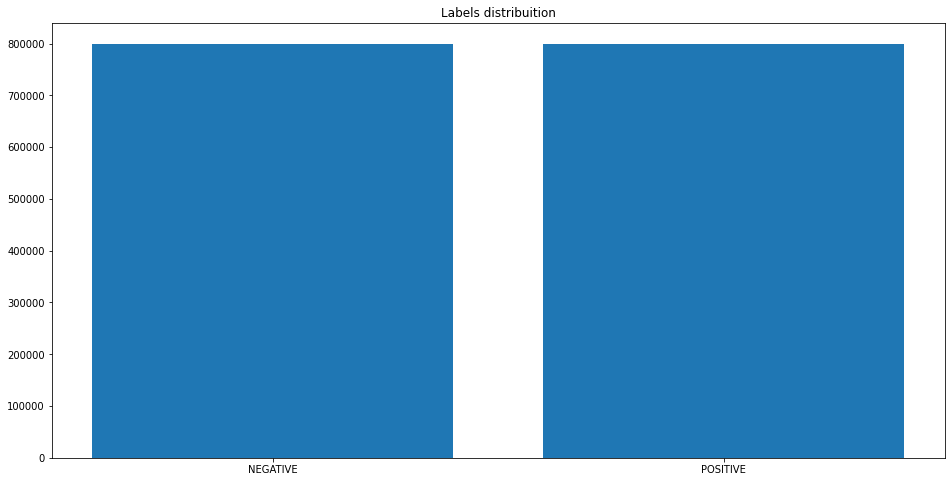

In [6]:
target_cnt = Counter(sentiment140.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Labels distribuition")

In [7]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
text_remove = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_remove, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [9]:
sentiment140.text = sentiment140.text.apply(lambda x: preprocess(x))

In [10]:
df_train, df_test = train_test_split(sentiment140, test_size=0.1, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1440000
TEST size: 160000


In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 313288


In [12]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

In [13]:
labels = df_train.target.unique().tolist()
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1440000, 1)
y_test (160000, 1)


In [14]:
batchsz = 512
data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
data = data.shuffle(10000).batch(batchsz,drop_remainder=True)

data_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
data_test = data_test.batch(batchsz,drop_remainder=True)

In [15]:
class Simple_LSTM(keras.Model):
  def __init__(self,units):
      super(Simple_LSTM, self).__init__()
      
      self.state_0 = [tf.zeros([batchsz,units])]
      
      #total words , embedding lens
      self.embedding = layers.Embedding(total_words,embedding_len,input_length=300)
      
      self.layer_1 = layers.SimpleRNNCell(units,dropout=0.1)
      
      self.out = layers.Dense(1)
      


  def call(self, inputs, training=None):
    
      x = self.embedding(inputs)
       
      state_0 = self.state_0
      for word in tf.unstack(x,axis=1):
          out,state_1 = self.layer_1(word,state_0)
          state_0 = state_1
      x = self.out(out)
      prob = tf.sigmoid(x)

      return prob

In [16]:
units = 128
epochs = 10
total_words=313288
embedding_len=128

rnn_model = Simple_LSTM(units)
rnn_model.compile(optimizer  =keras.optimizers.Adam(1e-4),loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])
rnn_model.fit(data,epochs=epochs, validation_data = data_test)

Epoch 1/10
2812/2812 [==============================] - 1146s 408ms/step - loss: 0.5031 - accuracy: 0.7540 - val_loss: 0.4639 - val_accuracy: 0.7827
Epoch 2/10
2812/2812 [==============================] - 1159s 412ms/step - loss: 0.4465 - accuracy: 0.7942 - val_loss: 0.4605 - val_accuracy: 0.7843
Epoch 3/10
2812/2812 [==============================] - 1155s 411ms/step - loss: 0.4225 - accuracy: 0.8085 - val_loss: 0.4667 - val_accuracy: 0.7823
Epoch 4/10
2812/2812 [==============================] - 1169s 416ms/step - loss: 0.3974 - accuracy: 0.8224 - val_loss: 0.4835 - val_accuracy: 0.7736
Epoch 5/10
2812/2812 [==============================] - 1182s 420ms/step - loss: 0.3768 - accuracy: 0.8337 - val_loss: 0.4837 - val_accuracy: 0.7746
Epoch 6/10
2812/2812 [==============================] - 1187s 422ms/step - loss: 0.3547 - accuracy: 0.8449 - val_loss: 0.5142 - val_accuracy: 0.7670
Epoch 7/10
2812/2812 [==============================] - 1183s 421ms/step - loss: 0.3297 - accuracy: 0.8563